In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

from misc import *
from dataset import *

import torch.nn as nn
import torch.optim as optim

from tqdm.auto import tqdm, trange

device = torch.device('cuda:0')

torch.manual_seed(111)
np.random.seed(222)


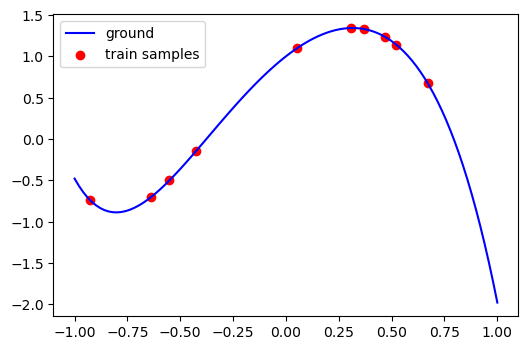

In [2]:
Ntr = 10
Xtr = torch.tensor(np.random.uniform(-1,1, size=[Ntr,1])).float().to(device)
Xte = torch.tensor(np.linspace(-1,1,100).reshape([-1,1])).float().to(device)

def poly(X):
    y = 1.0 + 2*X + (-2.4)*X**2 + (-1.5)*X**3 + 0.17*X**4 + (-1.25)*X**5
    return y

    
ytr = poly(Xtr).to(device)
yte = poly(Xte).to(device)

fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(Xtr.cpu().squeeze(), ytr.cpu().squeeze(), color='r', label='train samples')
plt.plot(Xte.cpu().squeeze(), yte.cpu().squeeze(), color='b', label='ground')
plt.legend()


Polynomial(
  (poly): (
    (0)poly_weights: torch.Size([11, 1])
  )
)


  0%|          | 0/10001 [00:00<?, ?it/s]

Epoch #0	: train_rmse=1.12654, test_rmse=1.09635
Epoch #1000	: train_rmse=0.47541, test_rmse=0.89149
Epoch #2000	: train_rmse=0.26754, test_rmse=0.68865
Epoch #3000	: train_rmse=0.13638, test_rmse=0.40981
Epoch #4000	: train_rmse=0.07792, test_rmse=0.20550
Epoch #5000	: train_rmse=0.06134, test_rmse=0.15095
Epoch #6000	: train_rmse=0.04908, test_rmse=0.18756
Epoch #7000	: train_rmse=0.03700, test_rmse=0.26443
Epoch #8000	: train_rmse=0.02739, test_rmse=0.32160
Epoch #9000	: train_rmse=0.01988, test_rmse=0.32034
Epoch #10000	: train_rmse=0.01280, test_rmse=0.27060


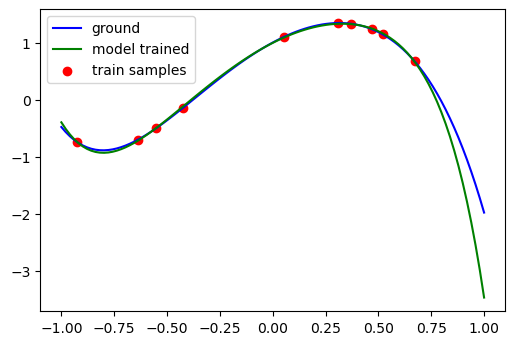

In [3]:

class Polynomial(nn.Module):
    def __init__(self, max_order=2):
        super().__init__()
        self.max_order = max_order
        self.weights = nn.Parameter(torch.randn(max_order+1,1))
        torch.nn.init.xavier_normal_(self.weights)
        
    def forward(self,X):
        design = []
        for e in range(self.max_order+1):
            design.append(torch.pow(X, e))
        #
        
        design = torch.hstack(design)
        
        y = torch.matmul(design, self.weights)
        
        return y
    
    def extra_repr(self):
        info = '(poly): ('
        info += '\n  (0)poly_weights: {}'.format(self.weights.shape)
        info += '\n)'
        return info
        
    
model = Polynomial(max_order=10).to(device)

print(model)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

epochs=10000
lr=1e-3
reg=1e-5

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

for ie in tqdm(range(epochs+1)):
    

    pred = model(Xtr)
    loss = torch.mean(torch.square(pred-ytr))
    

    # step 1: clear the grads
    optimizer.zero_grad()
    # step 2: backward the computational graph
    loss.backward()
    # step 3: take the gradient step
    optimizer.step()
    
    if ie%1000 == 0:
        cprint('r', 'Epoch #{}\t: '.format(ie), end='')
        with torch.no_grad():
            rmse_tr = torch.sqrt(torch.mean(torch.square(ytr-pred)))
            rmse_te = torch.sqrt(torch.mean(torch.square(yte-model(Xte))))
            print('train_rmse={:.5f}, test_rmse={:.5f}'.format(rmse_tr.item(), rmse_te.item()))
            
        #
    #

    

with torch.no_grad():
    pred = model(Xte)
    
fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

plt.scatter(Xtr.cpu().squeeze(), ytr.cpu().squeeze(), color='r', label='train samples')
plt.plot(Xte.cpu().squeeze(), yte.cpu().squeeze(), color='b', label='ground')
plt.plot(Xte.cpu().squeeze(), pred.cpu().squeeze(), color='green', label='model trained')
plt.legend()

In [4]:
import torch.nn.functional as F

class MyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        torch.nn.init.kaiming_normal_(self.weight)
        self.bias = nn.Parameter(torch.zeros(out_features,))
    def forward(self,X):
        y = torch.matmul(X, self.weight.T) + self.bias
        # y = F.linear(X, self.weight, self.bias)
        return y
    
class LogisticRegressor(nn.Module):
    def __init__(self, in_features):
        super(LogisticRegressor, self).__init__()
        self.linear = MyLinear(in_features, 1)
    def forward(self, X): 
        y = 1/(1+torch.exp(-self.linear(X)))
        # y = F.sigmoid(self.linear(X))
        return y
        

def metric_accuracy_binary(model, dataset, device):
    data_loader = DataLoader(dataset=dataset, batch_size=len(dataset), shuffle=False)
    X, y = next(iter(data_loader))
    
    X = X.float().to(device)
    y = y.long().to(device).squeeze()
    
    with torch.no_grad():
        pred = model(X)
        yhat = torch.hstack([1-pred, pred]).argmax(1)
        corr = torch.eq(yhat, y).int().sum()
        acc = corr.item()/len(dataset)    
        return acc
    

model = LogisticRegressor(in_features=4).to(device)

dataset_train = BankNote('data/bank-note', mode='train')
dataset_test = BankNote('data/bank-note', mode='test')

epochs=500
lr=1e-3
reg=1e-5
bz = 32

train_loader = DataLoader(dataset=dataset_train, batch_size=bz, shuffle=True, drop_last=False)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

loss_fn = nn.BCELoss()

for ie in tqdm(range(epochs+1)):
    
    for batch_idx, (X, y) in enumerate(train_loader):
        X = X.float().to(device)
        y = y.float().to(device).squeeze()
        pred = model(X).squeeze()
        
        loss = loss_fn(pred, y)
        # loss = -torch.mean(y*torch.log(pred) + (1 - y)* torch.log(1-pred))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #
    
    if ie%50 == 0:
        
        acc_tr = metric_accuracy_binary(model, dataset_train, device)
        acc_te = metric_accuracy_binary(model, dataset_test, device)
        cprint('r', 'Epoch #{}\t: '.format(ie), end='')
        print('train_acc={:.3f}, test_acc={:.3f}'.format(acc_tr, acc_te))
        
    

    


  0%|          | 0/501 [00:00<?, ?it/s]

Epoch #0	: train_acc=0.517, test_acc=0.500
Epoch #50	: train_acc=0.898, test_acc=0.894
Epoch #100	: train_acc=0.976, test_acc=0.980
Epoch #150	: train_acc=0.989, test_acc=0.988
Epoch #200	: train_acc=0.991, test_acc=0.990
Epoch #250	: train_acc=0.991, test_acc=0.990
Epoch #300	: train_acc=0.991, test_acc=0.990
Epoch #350	: train_acc=0.991, test_acc=0.990
Epoch #400	: train_acc=0.991, test_acc=0.990
Epoch #450	: train_acc=0.991, test_acc=0.990
Epoch #500	: train_acc=0.991, test_acc=0.990


In [5]:
class Net(nn.Module):
    def __init__(self, config):
        
        super(Net, self).__init__()
 
        layers_list = []

        for l in range(len(config)-1):
            in_dim = config[l]
            out_dim = config[l+1]           
            layers_list.append(MyLinear(in_features=in_dim, out_features=out_dim))
        #
        
        self.net = nn.ModuleList(layers_list)
        
    def forward(self, X):
        h = X
        for l in range(len(self.net)-1):
            layer = self.net[l]
            h = F.relu(layer(h))
        #
        h = self.net[-1](h)
        return h
    
def metric_accuracy_binary_logits(model, dataset, device):
    data_loader = DataLoader(dataset=dataset, batch_size=len(dataset), shuffle=False)
    X, y = next(iter(data_loader))
    
    X = X.float().to(device)
    y = y.long().to(device).squeeze()
    
    with torch.no_grad():
        logits = model(X)
        yhat = logits.argmax(1)
        corr = torch.eq(yhat, y).int().sum()
        acc = corr.item()/len(dataset)    
        return acc

    
config = [4, 64, 64, 2]
model = Net(config).to(device)

dataset_train = BankNote('data/bank-note', mode='train')
dataset_test = BankNote('data/bank-note', mode='test')

epochs=50
lr=1e-3
reg=1e-5
bz = 32

train_loader = DataLoader(dataset=dataset_train, batch_size=bz, shuffle=True, drop_last=False)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

for ie in tqdm(range(epochs+1)):
    
    for batch_idx, (X, y) in enumerate(train_loader):
        X = X.float().to(device)
        y = y.long().to(device).squeeze()

        logits = model(X)
        loss = F.cross_entropy(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #
    
    if ie%5 == 0:
        
        acc_tr = metric_accuracy_binary_logits(model, dataset_train, device)
        acc_te = metric_accuracy_binary_logits(model, dataset_test, device)
        cprint('r', 'Epoch #{}\t: '.format(ie), end='')
        print('train_acc={:.3f}, test_acc={:.3f}'.format(acc_tr, acc_te))


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch #0	: train_acc=0.959, test_acc=0.954
Epoch #5	: train_acc=1.000, test_acc=1.000
Epoch #10	: train_acc=1.000, test_acc=1.000
Epoch #15	: train_acc=1.000, test_acc=1.000
Epoch #20	: train_acc=1.000, test_acc=1.000
Epoch #25	: train_acc=1.000, test_acc=1.000
Epoch #30	: train_acc=1.000, test_acc=1.000
Epoch #35	: train_acc=1.000, test_acc=1.000
Epoch #40	: train_acc=1.000, test_acc=1.000
Epoch #45	: train_acc=1.000, test_acc=1.000
Epoch #50	: train_acc=1.000, test_acc=1.000
